In [10]:
import pandas as pd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def read_file(file):
    df = pd.read_csv(file)
    df = df.rename(columns={"trial number": "trial_number", 
                                "sample num": "sample_num", 
                                "sensor value": "sensor_value",
                                "sensor position": "sensor_position",
                                "subject identifier": "subject_identifier",
                                "matching condition": "matching_condition"})
    #check data
    assert len(df.trial_number.unique()) == 1
    trial_number = int(df.trial_number.unique()[0])
    assert len(df.sample_num.unique()) == 256
    sensor_positions = df.sensor_position.unique()
    assert len(df.subject_identifier.unique()) == 1
    subject = df.subject_identifier.unique()[0]
    assert len(df.channel.unique()) == 64
    assert len(df.name.unique()) == 1
    name = df.name.unique()[0]
    matching_condition = list(df.matching_condition.unique())
    ts = df.pivot(index="sample_num", columns="sensor_position", values="sensor_value")
    return {
        "trial_number": trial_number,
        "sensor_positions": sensor_positions,
        "name": name,
        "time_series": ts,
        "matching_condition": matching_condition,
        "subject_identifier": subject,
    }

In [11]:
train_files = Path(r'./SMNI_CMI_TRAIN').glob('**/*')
test_files = Path(r'./SMNI_CMI_TEST').glob('**/*')
train_files = [x for x in train_files if x.is_file()]
test_files = [x for x in test_files if x.is_file()]
train_data = dict()
test_data = dict()

for f in train_files:
    train_data[f] = read_file(f)

for f in test_files:
    test_data[f] = read_file(f)

In [6]:
train_classes = [1 if d["subject_identifier"] == "a" else 0 for d in train_data.values()]
test_classes = [1 if d["subject_identifier"] == "a" else 0 for d in test_data.values()]

In [4]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["time_series"].shape[1]

train_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(train_data.items()):
    ts = d["time_series"]
    train_stats["mean"][i], train_stats["max"][i], train_stats["min"][i], train_stats["median"][i], train_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [5]:
rows = len(test_data)
first_key = next(iter(test_data.keys()))
cols = test_data[first_key]["time_series"].shape[1]

test_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(test_data.items()):
    ts = d["time_series"]
    test_stats["mean"][i], test_stats["max"][i], test_stats["min"][i], test_stats["median"][i], test_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [7]:
X_train = np.hstack((train_stats["min"], train_stats["mean"], train_stats["max"], train_stats["median"], train_stats["std"]))
y_train = np.array(train_classes)
X_test = np.hstack((test_stats["min"], test_stats["mean"], test_stats["max"], test_stats["median"], test_stats["std"]))
y_test = np.array(test_classes)

In [17]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'multiclass',
    'num_class': 2,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1
}

In [18]:
model = lgb.train(params, 
                  train_data, 
                  num_boost_round=1000,
                  valid_sets=[train_data],
                  valid_names=['train'],
                  )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81582
[LightGBM] [Info] Number of data points in the train set: 936, number of used features: 320
[LightGBM] [Info] Start training from score -0.697430
[LightGBM] [Info] Start training from score -0.688883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

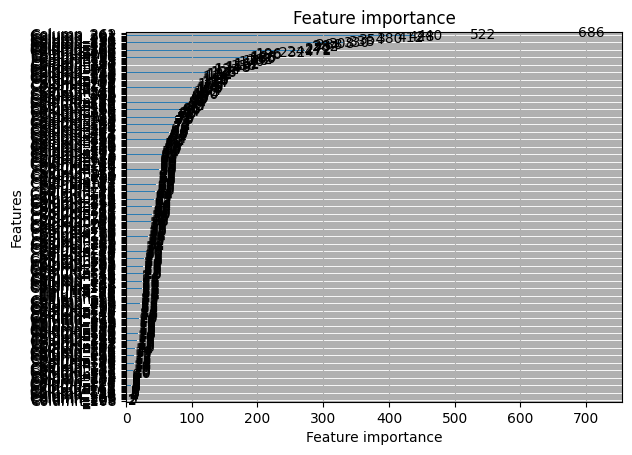

In [19]:
import matplotlib.pyplot as plt
lgb.plot_importance(model)
plt.show()

In [21]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

In [28]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

predicted = model.predict(X_test, num_iteration=model.best_iteration)
predicted

array([[6.52138559e-08, 9.99999935e-01],
       [3.85940133e-04, 9.99614060e-01],
       [9.99808919e-01, 1.91081168e-04],
       ...,
       [9.32590273e-01, 6.74097270e-02],
       [9.95392041e-01, 4.60795935e-03],
       [7.07584499e-02, 9.29241550e-01]])

In [25]:
class_predictions = np.argmax(y_pred, axis=1)
class_predictions

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [30]:
accuracy = accuracy_score(y_test, class_predictions)
print(f"Accuracy: {accuracy:.6f}")
f1 = f1_score(y_test, class_predictions)
print(f"F1 Score: {f1:.6f}")

Accuracy: 0.925000
F1 Score: 0.921397


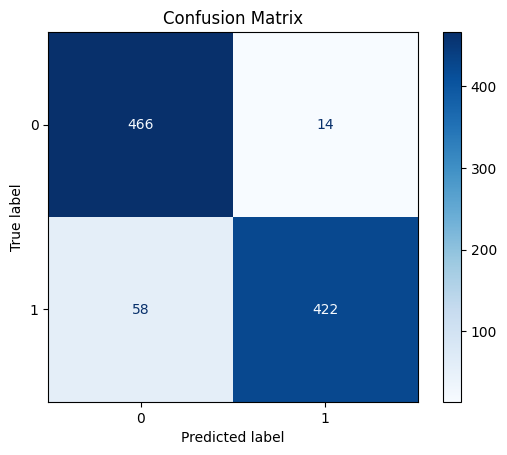

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, class_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()